In [1]:
from pyvela import SPNTA, pyvela_plot
import emcee
import numpy as np
import shutil
import os

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
spnta = SPNTA(
    parfile="NGC6440E.par",
    timfile="NGC6440E.tim",
    # custom_priors="NGC6440E_priors.json",
    cheat_prior_scale=100,
)

In [3]:
# Create the output directory and save the pre-analysis summary
result_dir = "NGC6440E_out"
if os.path.isdir(result_dir):
    shutil.rmtree(result_dir)
os.mkdir(result_dir)

spnta.save_pre_analysis_summary(result_dir)

In [4]:
nwalkers = spnta.ndim * 5
p0 = np.array(
    [spnta.prior_transform(cube) for cube in np.random.rand(nwalkers, spnta.ndim)]
)

In [5]:
spnta.lnpost_vectorized(p0)

40-element Vector{Float64}:
      -1.8032695413405267e6
      -1.7975859644293548e6
      -1.3300532735195265e6
  -63417.602432520005
 -118059.18816341752
  -57479.13027926575
  -11564.4986669688
 -469625.03381569026
  -68349.4657095374
      -1.235728377057659e6
       ⋮
  -31837.0377914709
      -3.4095611852420033e6
      -4.097183581733009e6
 -929023.5317188519
 -783789.4501130269
 -298036.1851883182
   -9147.078295001409
      -3.6437497660039277e6
 -379821.8828655611

In [6]:
sampler = emcee.EnsembleSampler(
    nwalkers, spnta.ndim, spnta.lnpost_vectorized, vectorize=True
)

In [7]:
sampler.run_mcmc(p0, 6000, progress=True);

100%|██████████| 6000/6000 [00:04<00:00, 1271.18it/s]


In [8]:
samples_raw = sampler.get_chain(flat=True, discard=1000, thin=50)
samples = spnta.rescale_samples(samples_raw)

In [9]:
F_ = spnta.model.param_handler._default_params_tuple.F_.x
shifts = np.array([0 if pname != "F0" else F_ for pname in spnta.param_names])

In [10]:
params_med_raw = np.median(samples_raw, axis=0)
params_med = spnta.rescale_samples(params_med_raw)
params_std = np.std(samples, axis=0)

print(f"Param\t{'Unit':<15}{'Value':<33}Units")
print("-" * 77)
for pname, punit, pval, pstd in zip(
    spnta.param_names, spnta.param_units, (params_med + shifts), params_std
):
    print(f"{pname}\t{punit:<15}{pval}\t+/-\t{pstd}")

Param	Unit           Value                            Units
-----------------------------------------------------------------------------
RAJ	hourangle      17.81466676418134	+/-	3.971350150676405e-08
DECJ	deg            -20.358162602565628	+/-	9.644727466864452e-06
PHOFF	1              0.09837402301628062	+/-	0.00044979733897662
DM	pc / cm3       224.11412914980775	+/-	0.034991747576761614
F0	Hz             61.485476554372184	+/-	1.881453888669327e-11
F1	Hz / s         -1.1813448541201936e-15	+/-	1.483134213828104e-18
EFAC1	1              1.0145260552344895	+/-	0.10376797777645913
EQUAD1	us             0.15760165077282995	+/-	4.733247237458134


In [11]:
spnta.save_results(result_dir, samples_raw)

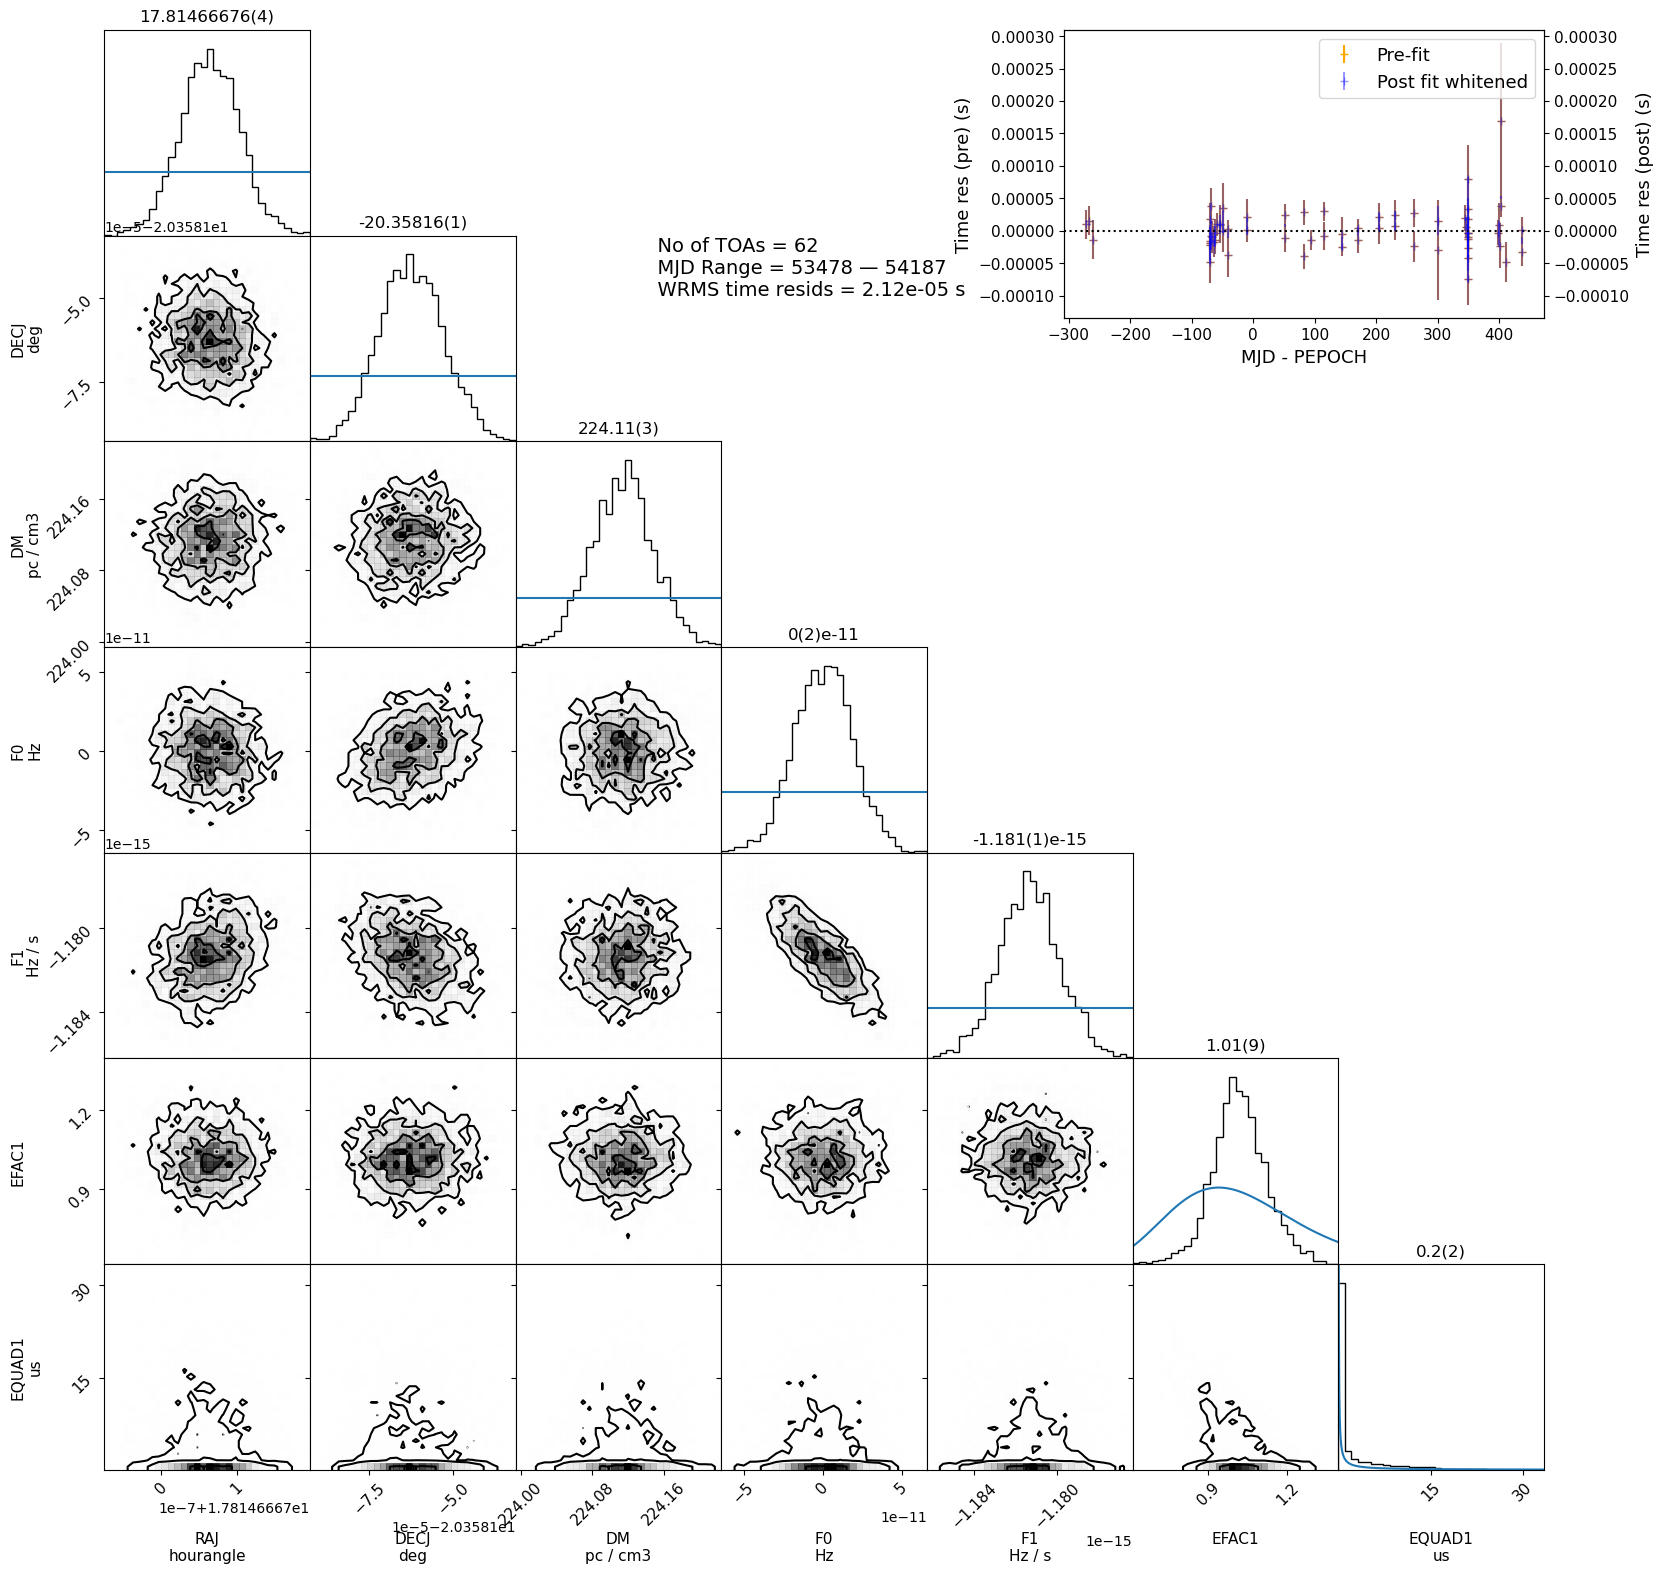

In [12]:
pyvela_plot.plot(result_dir, plot_priors=True, labelpad=0)

In [13]:
# pyvela J0613-0200.InPTA.NB.par J0613-0200.InPTA.NB.tim -o J0613-0200.InPTA.NB_out -M -C 100 -f
# pyvela-plot J0613-0200.InPTA.NB_out --priors